### XGBoost on Streptococcus agalactie

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold, KFold
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import plot_importance
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report,
    precision_recall_curve,
    average_precision_score
)

In [2]:
sa = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_SA.csv')

/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_87087/1538803325.py:1: DtypeWarning: Columns (66485) have mixed types. Specify dtype option on import or set low_memory=False.
  sa = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_SA.csv')


In [4]:
sa.shape

(409, 66486)

In [5]:
# Separate feature columns and target labels
X = sa.drop(columns=['AMG',"TET","BAC","sample_ID"], errors='ignore')

X['ST'] = pd.to_numeric(X['ST'], errors='coerce')  
X = X.dropna(subset=['ST'])

# Create individual datasets per antibiotic
# Split into features and labels
sa_amg = X.copy()
sa_amg['label'] = sa['AMG']
y_amg = sa_amg['label']

sa_tet = X.copy()
sa_tet['label'] = sa['TET']
y_tet = sa_tet['label']

sa_bac = X.copy()
sa_bac['label'] = sa['BAC']
y_bac = sa_bac['label']

In [6]:
# split into 80% train+val and 20% test
X_train_amg, X_test_amg, y_train_amg, y_test_amg = train_test_split(
    X, y_amg, test_size=0.3, random_state=42, stratify=y_amg)

X_train_tet, X_test_tet, y_train_tet, y_test_tet = train_test_split(
    X, y_tet, test_size=0.3, random_state=42, stratify=y_tet)

X_train_bac, X_test_bac, y_train_bac, y_test_bac = train_test_split(
    X, y_bac, test_size=0.3, random_state=42, stratify=y_bac)

# SMOTE only on training data
smote_amg = SMOTE(random_state=42)
X_train_resampled_amg, y_train_resampled_amg = smote_amg.fit_resample(X_train_amg, y_train_amg)

smote_bac = SMOTE(random_state=42, sampling_strategy='not majority', k_neighbors=3)
X_train_resampled_bac, y_train_resampled_bac = smote_bac.fit_resample(X_train_bac, y_train_bac)

print("AMG Resampled Class Distribution:", Counter(y_train_resampled_amg))
print("BAC Resampled Class Distribution:", Counter(y_train_resampled_bac))

# X_train_resampled_* for training (70%)
# X_test_* for testing (30%)

AMG Resampled Class Distribution: Counter({0: 208, 1: 208})
BAC Resampled Class Distribution: Counter({1: 222, 0: 222})


### Blocked cross-validation

In [7]:
hparam = {"eta":[0.1, 0.2, 0.4, 0.8]}

In [8]:
# Prepare X and groups (drop ST from X, but use it for grouping)
groups_amg = X_train_resampled_amg['ST'].values
X_train_input_amg = X_train_resampled_amg.drop(columns=['ST'])

# Prepare X and groups (drop ST from X, but use it for grouping)
groups_tet = X_train_tet['ST'].values
X_train_input_tet = X_train_tet.drop(columns=['ST'])

# Prepare X and groups (drop ST from X, but use it for grouping)
groups_bac = X_train_resampled_bac['ST'].values
X_train_input_bac = X_train_resampled_bac.drop(columns=['ST'])

##### 1. AMG

In [9]:
model_amg = XGBClassifier(random_state=42)

cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_amg, param_grid=hparam, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_amg, y_train_resampled_amg, groups=groups_amg, verbose=0)
params_amg = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

Best Accuracy: 0.9516
Best Parameters: {'eta': 0.1}


##### 2. TET

In [10]:
model_tet = XGBClassifier(random_state=42)

cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_tet, param_grid=hparam, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_tet, y_train_tet, groups=groups_tet, verbose=0)
params_tet = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

Best Accuracy: 0.9869
Best Parameters: {'eta': 0.1}


##### 3. BAC

In [11]:
model_bac = XGBClassifier(random_state=42)

cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_bac, param_grid=hparam, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_bac, y_train_resampled_bac, groups=groups_bac, verbose=0)
params_bac = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

Best Accuracy: 1.0000
Best Parameters: {'eta': 0.1}


### Trainig with best hyperparameters and testing

In [12]:
def run_GB(X_train, y_train, params):
  GB =  XGBClassifier(random_state = 42, eta=params['eta'])
  # Training XGB Classifier model
  GB = GB.fit(X_train, y_train)
  # Checking number of trees in the model
  print("Number of Decicion Trees in XGB Classifier model:", GB.get_booster().trees_to_dataframe().shape[0]
)
  return GB

In [13]:
def evaluate(model, X_train, y_train, X_test, y_test, threshold=0.5, model_name=None):
    """
    Evaluates a binary classification XGBoost model, compares training vs test accuracy,
    includes per-class metrics, and plots ROC and Precision-Recall curves.

    Parameters:
        model: Trained XGBoost model
        X_train, y_train: Training data (for overfitting check)
        X_test, y_test: Test data (for evaluation)
        threshold: Threshold for class prediction
    """
    # Predict probabilities
    y_test_prob = model.predict_proba(X_test)[:, 1]
    y_train_prob = model.predict_proba(X_train)[:, 1]

    # Apply threshold
    y_test_pred = (y_test_prob >= threshold).astype(int)
    y_train_pred = (y_train_prob >= threshold).astype(int)

    # Core metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, zero_division=0)
    rec = recall_score(y_test, y_test_pred, zero_division=0)
    f1 = f1_score(y_test, y_test_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_test_pred)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)

    # Classification report (per class)
    report = classification_report(
        y_test, y_test_pred, target_names=["Susceptible", "Resistant"], output_dict=True
    )

    # Display confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix for XGBoost model of {}".format(model_name))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for XGBoost model of {}'.format(model_name))
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Compute precision-recall values
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)

    # Compute PR AUC (Average Precision)
    pr_auc = average_precision_score(y_test, y_test_prob)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall Curve for XGBoost model of {}".format(model_name))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:     {test_acc:.4f}")
    print(f"Overall Precision: {prec:.4f}")
    print(f"Overall Recall:    {rec:.4f}")
    print(f"Overall F1 Score:  {f1:.4f}")
    print(f"ROC AUC:           {roc_auc:.4f}")

    print("\nPer-Class Performance:")
    for cls in ["Susceptible", "Resistant"]:
        cls_metrics = report[cls]
        print(f"{cls:12} | Precision: {cls_metrics['precision']:.2f} | Recall: {cls_metrics['recall']:.2f} | F1: {cls_metrics['f1-score']:.2f}")

    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=["Susceptible", "Resistant"]))

In [14]:
# Separate feature columns and target labels
X = sa.drop(columns=['AMG',"TET","BAC","sample_ID",'ST'], errors='ignore')

# Create individual datasets per antibiotic
# Split into features and labels
sa_amg = X.copy()
sa_amg['label'] = sa['AMG']
y_amg = sa_amg['label']

sa_tet = X.copy()
sa_tet['label'] = sa['TET']
y_tet = sa_tet['label']

sa_bac = X.copy()
sa_bac['label'] = sa['BAC']
y_bac = sa_bac['label']

# split into 80% train+val and 20% test
X_train_amg, X_test_amg, y_train_amg, y_test_amg = train_test_split(
    X, y_amg, test_size=0.3, random_state=42, stratify=y_amg)

X_train_tet, X_test_tet, y_train_tet, y_test_tet = train_test_split(
    X, y_tet, test_size=0.3, random_state=42, stratify=y_tet)

X_train_bac, X_test_bac, y_train_bac, y_test_bac = train_test_split(
    X, y_bac, test_size=0.3, random_state=42, stratify=y_bac)

# SMOTE only on training data
smote_amg = SMOTE(random_state=42)
X_train_resampled_amg, y_train_resampled_amg = smote_amg.fit_resample(X_train_amg, y_train_amg)

smote_bac = SMOTE(random_state=42, sampling_strategy='not majority')
X_train_resampled_bac, y_train_resampled_bac = smote_bac.fit_resample(X_train_bac, y_train_bac)

print("AMG Resampled Class Distribution:", Counter(y_train_resampled_amg))
print("BAC Resampled Class Distribution:", Counter(y_train_resampled_bac))

# X_train_resampled_* for training (70%)
# X_test_* for testing (30%)

AMG Resampled Class Distribution: Counter({0: 266, 1: 266})
BAC Resampled Class Distribution: Counter({1: 264, 0: 264})


##### 1. AMG

Number of Decicion Trees in XGB Classifier model: 730


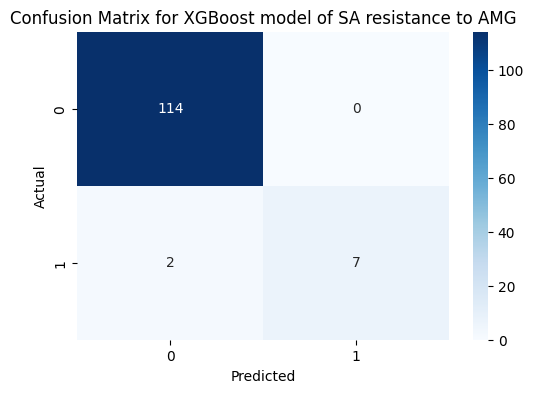

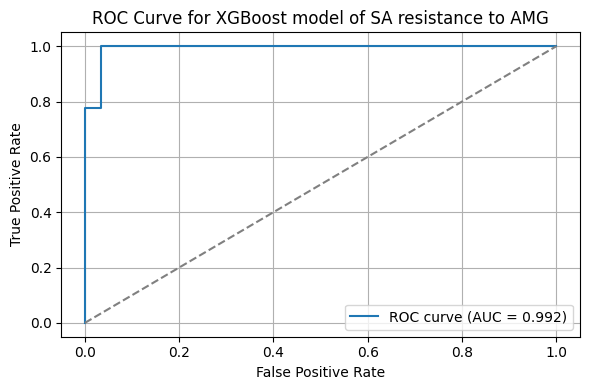

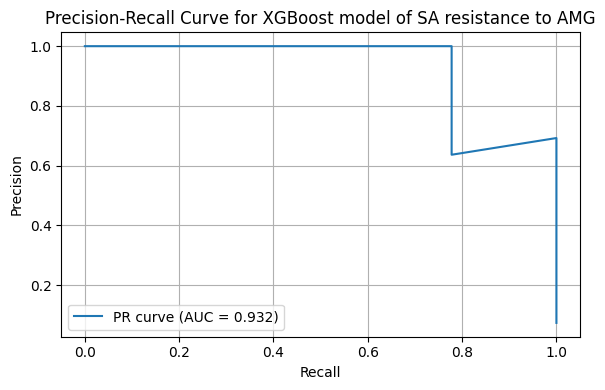

Training Accuracy: 1.0000
Test Accuracy:     0.9837
Overall Precision: 1.0000
Overall Recall:    0.7778
Overall F1 Score:  0.8750
ROC AUC:           0.9922

Per-Class Performance:
Susceptible  | Precision: 0.98 | Recall: 1.00 | F1: 0.99
Resistant    | Precision: 1.00 | Recall: 0.78 | F1: 0.88

Detailed Classification Report:
              precision    recall  f1-score   support

 Susceptible       0.98      1.00      0.99       114
   Resistant       1.00      0.78      0.88         9

    accuracy                           0.98       123
   macro avg       0.99      0.89      0.93       123
weighted avg       0.98      0.98      0.98       123



In [15]:
model_amg = run_GB(X_train_resampled_amg, y_train_resampled_amg, params_amg)
evaluate(model_amg, X_train_resampled_amg, y_train_resampled_amg, X_test_amg, y_test_amg, model_name='SA resistance to AMG')


##### 2. TET

Number of Decicion Trees in XGB Classifier model: 486


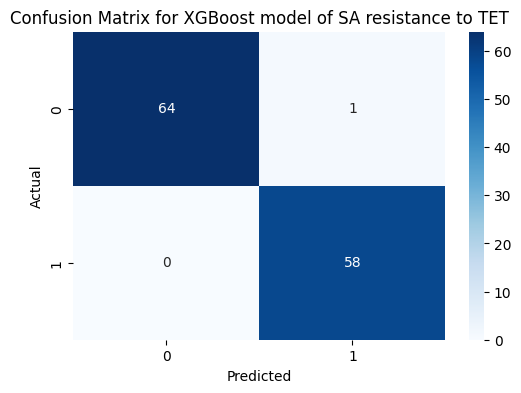

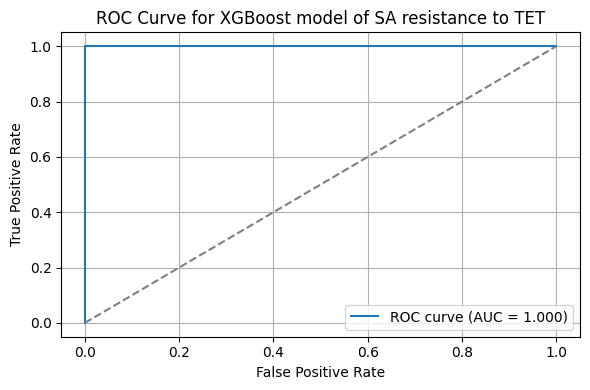

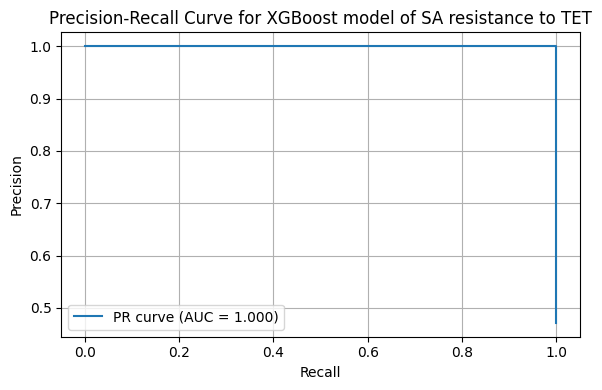

Training Accuracy: 1.0000
Test Accuracy:     0.9919
Overall Precision: 0.9831
Overall Recall:    1.0000
Overall F1 Score:  0.9915
ROC AUC:           1.0000

Per-Class Performance:
Susceptible  | Precision: 1.00 | Recall: 0.98 | F1: 0.99
Resistant    | Precision: 0.98 | Recall: 1.00 | F1: 0.99

Detailed Classification Report:
              precision    recall  f1-score   support

 Susceptible       1.00      0.98      0.99        65
   Resistant       0.98      1.00      0.99        58

    accuracy                           0.99       123
   macro avg       0.99      0.99      0.99       123
weighted avg       0.99      0.99      0.99       123



In [16]:
model_tet = run_GB(X_train_tet, y_train_tet, params_tet)
evaluate(model_tet, X_train_tet, y_train_tet, X_test_tet, y_test_tet, model_name='SA resistance to TET')

##### 3. BAC

Number of Decicion Trees in XGB Classifier model: 504


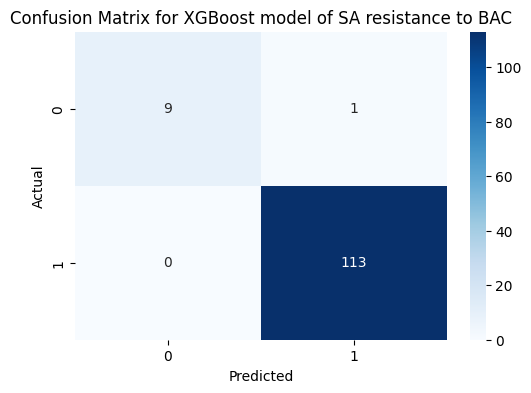

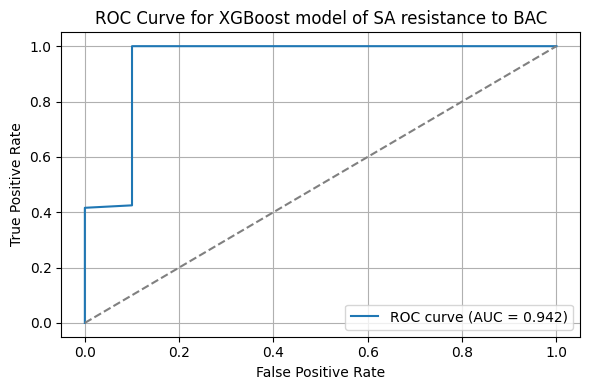

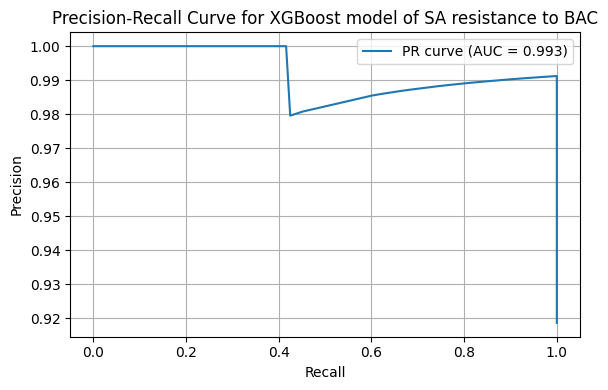

Training Accuracy: 1.0000
Test Accuracy:     0.9919
Overall Precision: 0.9912
Overall Recall:    1.0000
Overall F1 Score:  0.9956
ROC AUC:           0.9420

Per-Class Performance:
Susceptible  | Precision: 1.00 | Recall: 0.90 | F1: 0.95
Resistant    | Precision: 0.99 | Recall: 1.00 | F1: 1.00

Detailed Classification Report:
              precision    recall  f1-score   support

 Susceptible       1.00      0.90      0.95        10
   Resistant       0.99      1.00      1.00       113

    accuracy                           0.99       123
   macro avg       1.00      0.95      0.97       123
weighted avg       0.99      0.99      0.99       123



In [17]:
model_bac = run_GB(X_train_resampled_bac, y_train_resampled_bac, params_bac)
evaluate(model_bac, X_train_resampled_bac, y_train_resampled_bac, X_test_bac, y_test_bac, model_name='SA resistance to BAC')

### Feature importance

##### 1. AMG

In [18]:
booster_amg = model_amg.get_booster()

# Get feature importance by gain (how much each feature improves performance when used)
importance_dict = booster_amg.get_score(importance_type='gain')

# Sort features by gain (descending) and take the top 20
top_20_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]

# Print top 20
print("Top 20 features by importance (gain):")
for feature, score in top_20_features:
    print(f"{feature}: {score:.4f}")


Top 20 features by importance (gain):
SNP_21753: 69.8944
SNP_58112: 63.1727
group_164: 22.5894
SNP_12731: 20.5546
COQ3_2~~~COQ5: 17.4811
SNP_1839: 13.7876
group_2749: 12.9819
group_1514: 10.2233
group_2558: 5.3143
SNP_53989: 5.2803
group_2794: 5.0936
opuD_1~~~betL_1~~~betL: 4.0733
SNP_26734: 3.9493
SNP_56613: 3.9467
SNP_4146: 3.6640
essC_2~~~eccC~~~essC~~~essC_1: 2.7855
group_4019: 2.6516
SNP_21268: 2.5999
SNP_59611: 2.4423
group_3266: 2.1273


##### 2. TET

In [19]:
booster_tet = model_tet.get_booster()

# Get feature importance by gain (how much each feature improves performance when used)
importance_dict = booster_tet.get_score(importance_type='gain')

# Sort features by gain (descending) and take the top 20
top_20_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]

# Print top 20
print("Top 20 features by importance (gain):")
for feature, score in top_20_features:
    print(f"{feature}: {score:.4f}")


Top 20 features by importance (gain):
group_3309: 36.7113
group_2437: 16.4217
group_2596: 5.2304
SNP_28950: 4.3880
merA_1~~~merA_2~~~merA_3~~~merA_4~~~merA: 4.0287
SNP_5639: 3.6605
tetS~~~tetM_2~~~tetM_1~~~tetM~~~tetM: 3.6556
SNP_16859: 3.4080
group_3109: 3.3663
SNP_29106: 3.1304
SNP_6909: 2.5694
SNP_23153: 2.4149
SNP_40004: 1.7083
SNP_54228: 1.6667
SNP_13024: 1.6111
SNP_15860: 1.5278
group_3232: 1.3376
SNP_31685: 1.2369
group_4660: 1.0353
SNP_595: 1.0333


##### 3. BAC

In [20]:
booster_bac = model_bac.get_booster()

# Get feature importance by gain (how much each feature improves performance when used)
importance_dict = booster_bac.get_score(importance_type='gain')

# Sort features by gain (descending) and take the top 20
top_20_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]

# Print top 20
print("Top 20 features by importance (gain):")
for feature, score in top_20_features:
    print(f"{feature}: {score:.4f}")


Top 20 features by importance (gain):
SNP_13084: 52.5126
SNP_52232: 18.1868
group_2889: 11.5754
SNP_13075: 5.0248
SNP_30538: 3.8523
lnrL_2~~~drrA~~~cysA~~~lnrL: 1.7646
group_2886: 1.6400
SNP_2847: 1.5114
SNP_38834: 1.4042
SNP_29621: 1.1368
lagD_1~~~irtA~~~lagD_3~~~lagD_2~~~lagD: 0.9471
group_3086: 0.7961
SNP_29443: 0.7826
SNP_663: 0.7030
group_2375: 0.6276
SNP_29903: 0.3681
manX_2: 0.3428
group_2272: 0.2991
group_1904: 0.2693
SNP_20889: 0.2202
